In [1]:
from qiskit import *
from math import pi
import math
import numpy as np
from qiskit.aqua.operators import CircuitStateFn
from qiskit.aqua.operators.gradients import QFI
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
import time

In [2]:
numQubits = 4  #Number of Qubits in the circuit
numParametrisedLayers = 2

In [3]:
X = np.random.uniform(-1, 1, numQubits)  #data vector X, normalised between [-1, 1]

In [4]:
params = ParameterVector('θ_', length = numQubits*numParametrisedLayers) #vector of parameters (for the Variational Circuit)
theta_iter = iter(params) #iterates over the instances of vector "params"

In [5]:
def add_layerRZ():
    for i in range(numQubits):
        qf.rz(X[i], i)
    qf.barrier()

In [6]:
def add_layerRZZ():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qf.cx(i, j)
            qf.rz((pi-X[i])*(pi-X[j]), j)
            qf.cx(i, j)
        qf.barrier()

In [7]:
def make_feature_map():
    for i in range(numQubits):
        qf.h(i)
    qf.barrier()
    add_layerRZ()
    add_layerRZZ()

In [8]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qf.cx(i, j)
    qf.barrier()

In [9]:
def add_layerRY():
    for qubit in range(numQubits):
        qf.ry(next(theta_iter), qubit)
    qf.barrier()

In [10]:
def make_variationalCircuit():
    add_layerRY()
    add_cnots()
    add_layerRY()

In [11]:
qf = QuantumCircuit(QuantumRegister(numQubits)) 

In [12]:
def make_final_circuit():
    make_feature_map()
    make_variationalCircuit()

In [13]:
make_final_circuit()

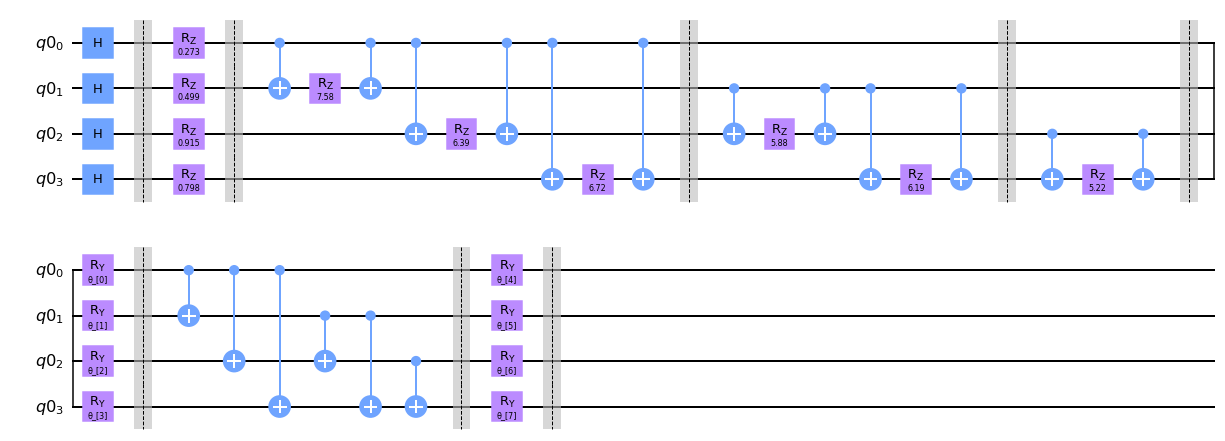

In [14]:
qf.draw('mpl')

In [15]:
state = CircuitStateFn(primitive=qf, coeff=1.)

In [16]:
start_qfi = time.time()
qfi = qiskit.aqua.operators.gradients.QFI(qfi_method='lin_comb_full').convert(operator=state, params=params.params)
values_dict = {params: np.random.uniform(-1, 1, numQubits*numParametrisedLayers)} 
qfi_result = qfi.assign_parameters(values_dict).eval()
end_qfi = time.time()
print(end_qfi - start_qfi)

36.821410179138184


In [17]:
print('full QFI \n', np.real(np.array(qfi_result)))

full QFI 
 [[ 0.99571295  0.03842591 -0.12072346 -0.03843345  0.16687284 -0.04848222
   0.19588431 -0.1173373 ]
 [ 0.03842591  0.98594622  0.04746645  0.21134102  0.01528749 -0.02126926
   0.01787013  0.13998497]
 [-0.12072346  0.04746645  0.8765223   0.39029879  0.04531414 -0.26019409
   0.18323305  0.22244864]
 [-0.03843345  0.21134102  0.39029879  0.90254175  0.04025769 -0.23115989
   0.04705874  0.08921181]
 [ 0.16687284  0.01528749  0.04531414  0.04025769  0.98337051 -0.15874359
  -0.12337335  0.19982901]
 [-0.04848222 -0.02126926 -0.26019409 -0.23115989 -0.15874359  0.45171504
  -0.12510553 -0.18577747]
 [ 0.19588431  0.01787013  0.18323305  0.04705874 -0.12337335 -0.12510553
   0.97727719  0.11547279]
 [-0.1173373   0.13998497  0.22244864  0.08921181  0.19982901 -0.18577747
   0.11547279  0.59925237]]


In [18]:
fisher_matrix = np.real(np.array(qfi_result))

In [19]:
def V_theta(n):
    return (2*pi)**n

In [20]:
def normalised_matrix():
    denominator = 2*pi*np.trace(fisher_matrix)          #integrate.quad(np.trace(fisher_matrix), 0, 2*pi)
    d = numQubits*numParametrisedLayers
    return d*(V_theta(n)/denominator)*fisher_matrix

In [21]:
def effective_dimension():
    factor = (gamma*n)/(2*pi*math.log10(n))
    determinant = np.linalg.det(factor*fisher_matrix + np.identity(fisher_matrix.shape[0]))
    integrate_det = 2*pi*determinant**0.5
    return 2*math.log10(integrate_det/V_theta(n))/math.log10(factor)

In [22]:
n = 2 #no of data samples (can't be taken as 1, otherwise log(1) gives division by zero error)
gamma = np.random.random()

In [29]:
start_ed = time.time()
print("Effective Dimension : {}".format(effective_dimension())) 
end_ed = time.time()
print(end_ed - start_ed)

Effective Dimension : 1.3444728327829778
0.00044846534729003906
